In [1]:
import cv2
import mediapipe as mp
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline

mp_pose = mp.solutions.pose

# Symmetry

Postural Symmetry checks implemented as follow:

$hs(t_{i})$ = $\displaystyle \frac{||x^{tc}(t_{i})-x^{LH}(t_{i})|-|x^{tc}(t_{i})-x^{RH}(t_{i})||}{|x^{tc}(t_{i})-x^{LH}(t_{i})|+|x^{tc}(t_{i})-x^{RH}(t_{i})|}$

$vs(t_{i})$ = $\displaystyle \frac{||y^{tc}(t_{i})-y^{LH}(t_{i})|-|y^{tc}(t_{i})-y^{RH}(t_{i})||}{|y^{tc}(t_{i})-y^{LH}(t_{i})|+|y^{tc}(t_{i})-y^{RH}(t_{i})|}$

where hands are $p^{LH}$ and $p^{RH}$, and barycenter with $p^{tc}$

In [2]:
def compute_asymmetry(lhand, rhand, spine, axis):
    return abs(abs(spine[axis] - lhand[axis])-abs(spine[axis] - rhand[axis]))/abs(abs(spine[axis] - lhand[axis])+abs(spine[axis] - rhand[axis]))

In [3]:
def is_pose_symmetric(lhand, rhand, spine,threshold=0.16):
        
    h_asymmetry = compute_asymmetry(lhand, rhand, spine, "x")
    v_asymmetry = compute_asymmetry(lhand, rhand, spine, "y")

    asymmetry_score = (h_asymmetry + v_asymmetry) / 2

    if(asymmetry_score<threshold):
        return True
    else:
        return False

In [4]:
use_webcam = False #False to use a stored video
previous_symmetries_prediction=[] #prediction based on single frame
last_frames_considered = 50
previous_symmetries_prediction_cleaned=[] #prediction based on last last_frames_considered frames

if use_webcam:
    cap = cv2.VideoCapture(cv2.CAP_DSHOW)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for wrists and hips
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles at previous landmarks
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0} #spine (point between hips), assumed to be the barycenter
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)     
        
        # Prediction
        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}

        symmetry_prediction_single_frame = is_pose_symmetric(l_hand,r_hand,spine)
        
        
        previous_symmetries_prediction.append(symmetry_prediction_single_frame)   
        
        #count if there are more symmetries or asymmetries frames in last specified
        previous_symmetries_prediction_cleaned.append(len([elem for elem in previous_symmetries_prediction[-last_frames_considered:] if elem]) > len([elem for elem in previous_symmetries_prediction[-last_frames_considered:] if not elem]))

        # Prediction box
        if(previous_symmetries_prediction_cleaned[-1]):
            rect_color=(255,0,0)
            rect_text="Symmetric"
        else:
            rect_color=(0,0,255)
            rect_text="Non Symmetric"

        cv2.rectangle(frame, (0,0), (270,100), rect_color, -1)
        
        cv2.putText(frame,rect_text, 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)


        cv2.imshow('Mediapipe Feed', frame)

        #stop predictions when 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1707906972.754269       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


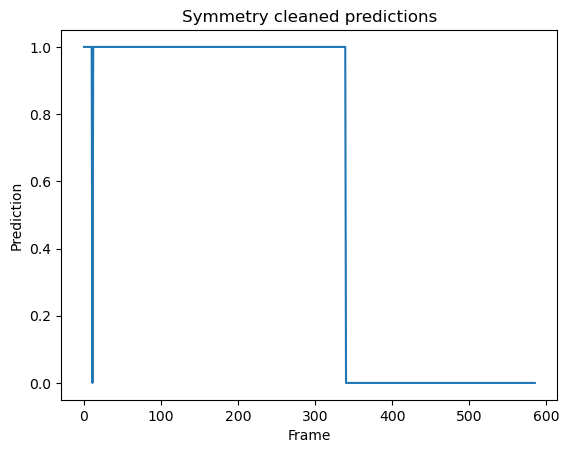

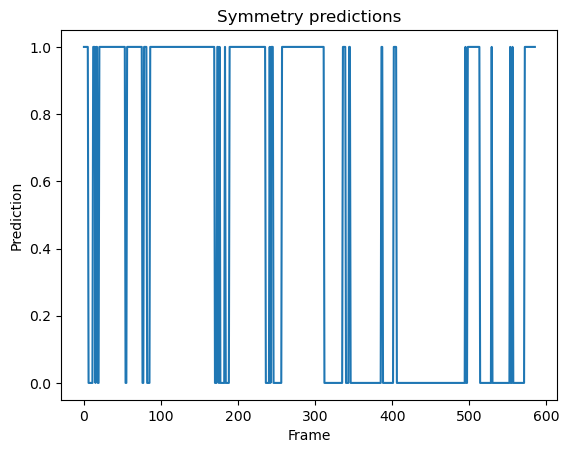

In [5]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(previous_symmetries_prediction_cleaned)), previous_symmetries_prediction_cleaned)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Symmetry cleaned predictions")
plt.show()

plt.figure()
plt.plot(range(len(previous_symmetries_prediction)), previous_symmetries_prediction)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Symmetry predictions")
plt.show()

# Compactness

Compactness computed as follow. No normalizations are done because the interest is related not to a compactness index, but only on its variation

$as(t_{i})$ = $||p^{H}(t_{i})-p^{SP}(t_{i})||$

Arm shape: Magnitude of the vector from hand (taken as landmark $p^{H}$) to base of the spine (landmark $p^{SP}$) :

In [5]:
def compute_volume_variation(lhand, rhand, spine):
    volume = 0
    
    for hand in [lhand, rhand]:
        # Compute the vector from hand to base of the spine
        vector_x = spine["x"] - hand["x"]
        vector_y = spine["y"] - hand["y"]

        # Compute the magnitude of the vector
        volume = volume + math.sqrt(vector_x**2 + vector_y**2)
    
    return volume

In [6]:
use_webcam = False #False to use a stored video

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

previous_volumes=[] #volumes of each frame
last_frames_considered = 15
previous_predictions=[] #predictions, based on last_frames_considered volumes, of each frame

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles at specific landmarks
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0}
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)        

        
        # Compute body volume
        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        volume = compute_volume_variation(l_hand,r_hand,spine)
                                          
        # Check if the current volume is greater or lower the previous last_frames_considered ones, in order to make a prediction
        last_n_volumes = previous_volumes[-last_frames_considered:]
        greater_count = sum(1 for element in last_n_volumes if element > volume)
        lower_count = sum(1 for element in last_n_volumes if element < volume)
         
        previous_volumes.append(volume)   

        #Prediction computation
        if(greater_count < lower_count):
            previous_predictions.append(True)
        else:
            previous_predictions.append(False)

        # Prediction box    
        if(previous_predictions[-1]):
            rect_color=(255,0,0)
            rect_text="Increasing volume"
        else:
            rect_color=(0,0,255)
            rect_text="Decreasing volume"

        cv2.rectangle(frame, (0,0), (270,100), rect_color, -1)
        
        cv2.putText(frame,rect_text, 
                    (10,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1707906994.016870       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


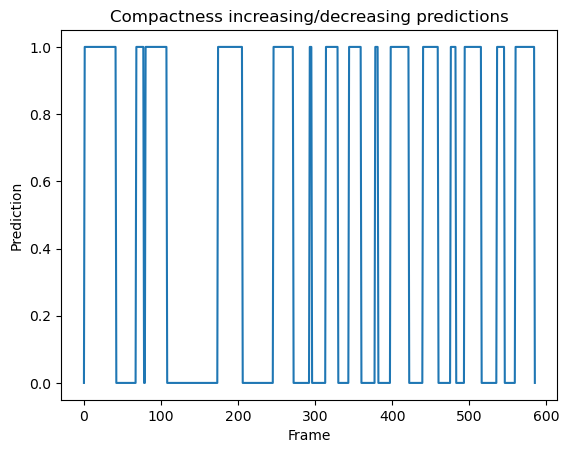

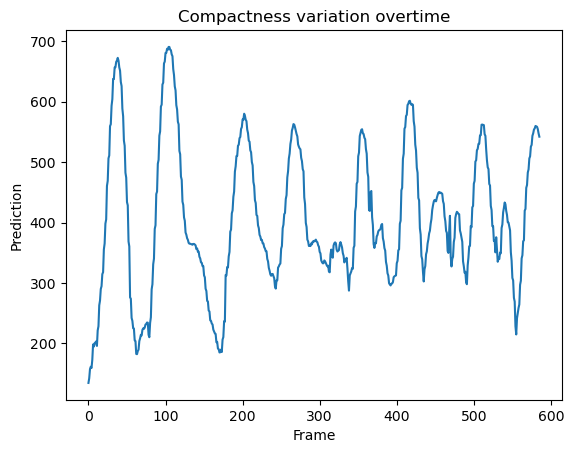

In [7]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(previous_predictions)), previous_predictions)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Compactness increasing/decreasing predictions")
plt.show()

plt.figure()
plt.plot(range(len(previous_volumes)), previous_volumes)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Compactness variation overtime")
plt.show()

# Wrist speed

The velocity of each wrist is computed in the following way:

$v^{k}(t_{i})$ = $\displaystyle \frac{p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})}{t_{i}-t_{i-last\_frames\_considered}}$

Their speed is computed as:
$v^{k}(t_{i})$ = $\sqrt{(v^{k}_{x}(t_{i}))^2+(v^{k}_{y}(t_{i}))^2}$

In [8]:
# the implementation assumes that all _past and _now couples used have the same temporal distance between them

def compute_speed(lhand_past, lhand_now, rhand_past, rhand_now,dt):
    
    # Compute the speed of left and right hand
    speed_lhand = math.sqrt(((lhand_past["x"] - lhand_now["x"])/dt)**2 + ((lhand_past["y"] - lhand_now["y"])/dt)**2)
    speed_rhand = math.sqrt(((rhand_past["x"] - rhand_now["x"])/dt)**2 + ((rhand_past["y"] - rhand_now["y"])/dt)**2)
    
    return round((speed_lhand + speed_rhand),2)

In [9]:
use_webcam = False #False to use a stored video
last_frames_considered = 2 #eventually used to reduce noise
speed = None

if use_webcam:
    cap = cv2.VideoCapture(0)
    sec_betw_last_frames_considered = 1 #cannot be evaluated with webcam

else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    sec_betw_last_frames_considered = (1/fps)*last_frames_considered

speed_predictions=[] #predictions containg instantaneous speed
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break

        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break

        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        
        # Draw circles at specific landmarks
        if(len(lhand_previous_positions)>=last_frames_considered):
            for hand in lhand_previous_positions[-last_frames_considered:]+rhand_previous_positions[-last_frames_considered:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

            
        for index in [left_wrist_index, right_wrist_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position              

        
        # Compute body volume
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed with second last position to reduce noise
        if(len(lhand_previous_positions)>=last_frames_considered):
            speed = compute_speed(lhand_previous_positions[-last_frames_considered],lhand,rhand_previous_positions[-last_frames_considered],rhand,sec_betw_last_frames_considered)
            speed_predictions.append(speed)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        # Prediction box
        if speed is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'Speed: '+str(speed), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1707907014.982739       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


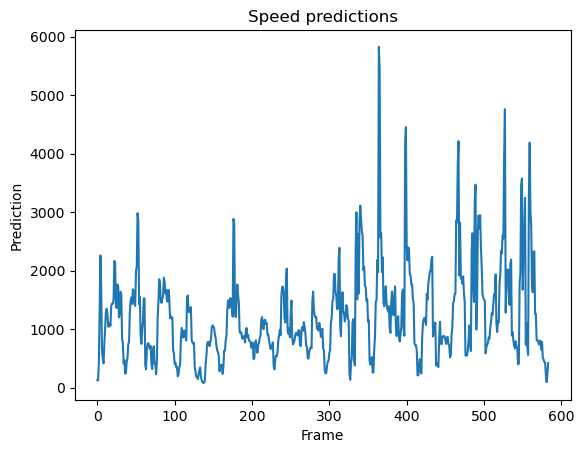

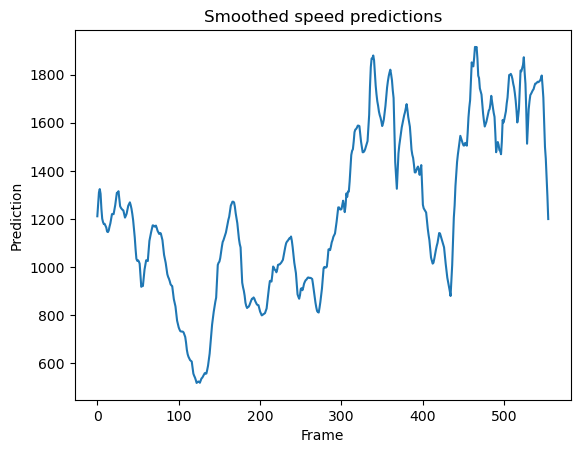

In [10]:
# Plotting Graphs
plt.figure()
plt.plot(range(len(speed_predictions)), speed_predictions)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Speed predictions")
plt.show()

window_size = 30
smoothed_prediction = np.convolve(speed_predictions, np.ones(window_size)/window_size, mode='valid')
plt.figure()
plt.plot(range(len(smoothed_prediction)), smoothed_prediction)
plt.xlabel("Frame")
plt.ylabel("Prediction")
plt.title("Smoothed speed predictions")
plt.show()

# Wrist trajectory

Foreach wrist, its trajectory is computed as 

$d^{k}(t_{i})$ = $\displaystyle \frac{p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})}{||p^{k}(t_{i})-p^{k}(t_{i-last\_frames\_considered})||}$

In [11]:
def compute_trajectory(lhand_past, lhand_now, rhand_past, rhand_now):
    
    # Compute direction of movement of both hands
    direction_lhand_x = round((lhand_now["x"]-lhand_past["x"])/math.sqrt((lhand_now["x"]-lhand_past["x"])**2+(lhand_now["y"]-lhand_past["y"])**2),2)
    direction_lhand_y = round((lhand_now["y"]-lhand_past["y"])/math.sqrt((lhand_now["x"]-lhand_past["x"])**2+(lhand_now["y"]-lhand_past["y"])**2),2)
    direction_rhand_x = round((rhand_now["x"]-rhand_past["x"])/math.sqrt((rhand_now["x"]-rhand_past["x"])**2+(rhand_now["y"]-rhand_past["y"])**2),2)
    direction_rhand_y = round((rhand_now["y"]-rhand_past["y"])/math.sqrt((rhand_now["x"]-rhand_past["x"])**2+(rhand_now["y"]-rhand_past["y"])**2),2)

    return [direction_lhand_x,direction_lhand_y],[direction_rhand_x,direction_rhand_y]

In [12]:
use_webcam = False #False to use a stored video
last_frames_considered = 2 #eventually used to reduce noise
ltrajectory = None
rtrajectory = None

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

ltrajectory_predictions=[] #predictions containg direction of movement of left wrist
rtrajectory_predictions=[] #predictions containg direction of movement of right wrist
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break

        if use_webcam:
            frame = cv2.flip(frame, 1)


        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        
        # Draw circles for trajectories
        if(len(lhand_previous_positions)>=last_frames_considered):
            for hand in lhand_previous_positions[-last_frames_considered:]+rhand_previous_positions[-last_frames_considered:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

        #draw landmark circles
        for index in [left_wrist_index, right_wrist_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
                
        # Compute hand coordinates
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed trajectories
        if(len(lhand_previous_positions)>=last_frames_considered):
            ltrajectory, rtrajectory= compute_trajectory(lhand_previous_positions[-last_frames_considered],lhand,rhand_previous_positions[-last_frames_considered],rhand)
            
            ltrajectory_predictions.append(ltrajectory)
            rtrajectory_predictions.append(rtrajectory)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        # Prediction box
        if ltrajectory is not None:
            cv2.rectangle(frame, (width-270,0), (width,100), (255,0,0), -1)

            cv2.putText(frame,'L: '+str(ltrajectory), 
                        (width-260,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        if rtrajectory is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'R: '+str(rtrajectory), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)


        cv2.imshow('Mediapipe Feed', frame)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1707907041.135115       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


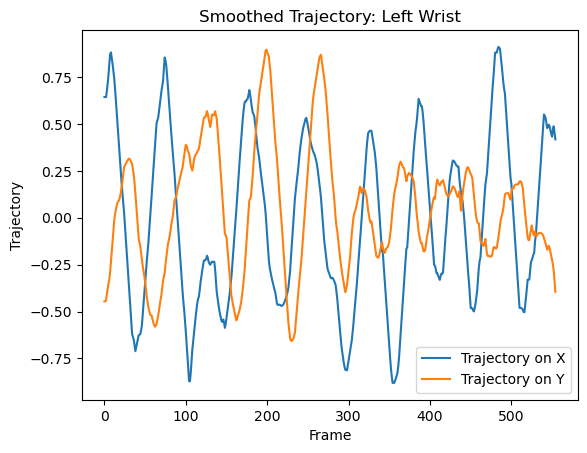

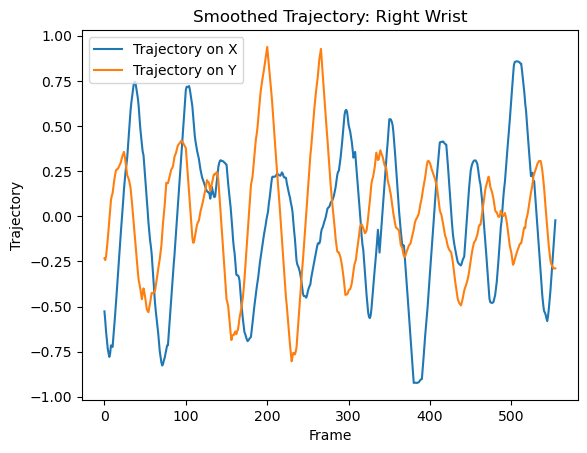

In [14]:
window_size = 30

# Smoothing L
ltrajectory_smoothed={}
ltrajectory_smoothed["x"] = np.convolve([axis[0] for axis in ltrajectory_predictions], np.ones(window_size)/window_size, mode='valid')
ltrajectory_smoothed["y"] = np.convolve([axis[1] for axis in ltrajectory_predictions], np.ones(window_size)/window_size, mode='valid')

# Plotting Graphs
plt.figure()
plt.plot(range(len(ltrajectory_smoothed["x"])), ltrajectory_smoothed["x"], label='Trajectory on X')
plt.plot(range(len(ltrajectory_smoothed["y"])), ltrajectory_smoothed["y"], label='Trajectory on Y')
plt.xlabel("Frame")
plt.ylabel("Trajectory")
plt.title("Smoothed Trajectory: Left Wrist")
plt.legend()
plt.show()

# Smoothing R
rtrajectory_smoothed={}
rtrajectory_smoothed["x"] = np.convolve([axis[0] for axis in rtrajectory_predictions], np.ones(window_size)/window_size, mode='valid')
rtrajectory_smoothed["y"] = np.convolve([axis[1] for axis in rtrajectory_predictions], np.ones(window_size)/window_size, mode='valid')

# Plotting Graphs
plt.figure()
plt.plot(range(len(rtrajectory_smoothed["x"])), rtrajectory_smoothed["x"], label='Trajectory on X')
plt.plot(range(len(rtrajectory_smoothed["y"])), rtrajectory_smoothed["y"], label='Trajectory on Y')
plt.xlabel("Frame")
plt.ylabel("Trajectory")
plt.title("Smoothed Trajectory: Right Wrist")
plt.legend()
plt.show()

# Plotting Graphs
#if(len(rtrajectory_smoothed["x"])==len(ltrajectory_smoothed["x"])): 
#    overall_trajectory_smoothed={"x":[],"y":[]}
#    
#    for elem1, elem2 in zip(rtrajectory_smoothed["x"], ltrajectory_smoothed["x"]):
#        overall_trajectory_smoothed["x"].append((elem1 + elem2)/2)
#        
#    for elem1, elem2 in zip(rtrajectory_smoothed["y"], ltrajectory_smoothed["y"]):
#        overall_trajectory_smoothed["y"].append((elem1 + elem2)/2)
#    
#    
#    plt.figure()
#    plt.plot(range(len(overall_trajectory_smoothed["x"])), overall_trajectory_smoothed["x"], label='Trajectory on X')
#    plt.plot(range(len(overall_trajectory_smoothed["y"])), overall_trajectory_smoothed["y"], label='Trajectory on Y')
#    plt.xlabel("Frame")
#    plt.ylabel("Trajectory")
#    plt.title("Overall mean of Wrists Trajectory")
#    plt.legend()
#    plt.show()

# Classification

Added simple movement classifier:
If movement is symmetric and the x component of the wrists trajectory is higher then the y one: **Forward movement**
If movement is symmetric and the y component of the wrists trajectory is higher then the x one: **Backward movement**
If movement is asymmetric and the x component of a "row" is mostly positive (to the right): **Left movement**
If movement is asymmetric and the x component of a "row" is mostly negative (to the left): **Right movement**

In [13]:
def compute_peaks(trajectory, prev_peak, axis = "x", direction="max"):
    #if over/under of prev peak + if is local max
    if(direction=="max"):
        
        if((trajectory[axis][-2]>prev_peak[direction]) | ((trajectory[axis][-2]>trajectory[axis][-3]) & (trajectory[axis][-2]>trajectory[axis][-1]))):
            return trajectory[axis][-2]
    else:
        if((trajectory[axis][-2]<prev_peak[direction]) | ((trajectory[axis][-2]<trajectory[axis][-3]) & (trajectory[axis][-2]<trajectory[axis][-1]))):
            return trajectory[axis][-2]
   
    return prev_peak[direction]

In [14]:
use_webcam = False #False to use a stored video
last_frames_considered_symmetry = 50
last_frames_considered_trajectory = 2
window_size_convolution = 30
previous_symmetries_prediction=[]
previous_symmetries_prediction_cleaned=[]
movement_class_predictions=[] #movements prediction
movement_class=""


ltrajectory = None
rtrajectory = None

x_peak={"min":1,"max":-1}
y_peak={"min":1,"max":-1}

if use_webcam:
    cap = cv2.VideoCapture(0)
else:
    video_path = 'GestureFeatureResources/video.mov'
    cap = cv2.VideoCapture(video_path)

ltrajectory_predictions=[] #predictions containg direction of movement of left wrist
rtrajectory_predictions=[] #predictions containg direction of movement of right wrist
lhand_previous_positions=[]
rhand_previous_positions=[]

# Setup mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        if frame is None: # if stored video is finished, exit
            break
            
        if use_webcam:
            frame = cv2.flip(frame, 1)

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      
        # Make detection
        results = pose.process(image)
    
        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            print("Error extracting landmarks")
            break
        
        # Indices for the nose, shoulders, elbows, and wrists
        left_wrist_index = 15
        right_wrist_index = 16
        left_hip_index = 23
        right_hip_index = 24
        
        # Draw circles for trajectories
        if(len(lhand_previous_positions)>=last_frames_considered_trajectory):
            for hand in lhand_previous_positions[-last_frames_considered_trajectory:]+rhand_previous_positions[-last_frames_considered_trajectory:]:
                cv2.circle(frame, (int(hand["x"]), int(hand["y"])), 3, (0, 255, 0), -1)  # Draw a circle at the landmark position              

        #draw landmark circles
        for index in [left_wrist_index, right_wrist_index, left_hip_index, right_hip_index]:
            landmark = landmarks[index]
            height, width, _ = frame.shape
            cx, cy = int(landmark.x * width), int(landmark.y * height)
            cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)  # Draw a circle at the landmark position
        
        spine = {'x': 0.0, 'y': 0.0} #spine (point between hips), assumed to be the barycenter
        spine["x"] = int(((landmarks[left_hip_index].x * width) + (landmarks[right_hip_index].x * width)) / 2)
        spine["y"] = int(((landmarks[left_hip_index].y * height) + (landmarks[right_hip_index].y * height)) / 2)
        cv2.circle(frame, (spine["x"], spine["y"]), 5, (0, 0, 255), -1)  # Draw a circle at the landmark position

        
        # Connect wrists with spine
        cv2.line(frame, (int(landmarks[left_wrist_index].x * width), int(landmarks[left_wrist_index].y * height)),
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)

        cv2.line(frame, (int(landmarks[right_wrist_index].x * width), int(landmarks[right_wrist_index].y * height)), 
                 (int(spine["x"]), int(spine["y"])),
                 (0, 255, 0), 2)   
        
        # Compute hand coordinates
        lhand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        rhand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}
        
        #computed trajectories
        if(len(lhand_previous_positions)>=last_frames_considered_trajectory):
            ltrajectory, rtrajectory= compute_trajectory(lhand_previous_positions[-last_frames_considered_trajectory],lhand,rhand_previous_positions[-last_frames_considered_trajectory],rhand)
            
            ltrajectory_predictions.append(ltrajectory)
            rtrajectory_predictions.append(rtrajectory)
        
        lhand_previous_positions.append(lhand)    
        rhand_previous_positions.append(rhand)                               

        l_hand = {'x':landmarks[left_wrist_index].x*width, 'y':landmarks[left_wrist_index].y*height}
        r_hand = {'x':landmarks[right_wrist_index].x*width, 'y':landmarks[right_wrist_index].y*height}

        symmetry_prediction_single_frame = is_pose_symmetric(l_hand,r_hand,spine)
        
        
        previous_symmetries_prediction.append(symmetry_prediction_single_frame)   
        
        #count if there are more symmetries or asymmetries frames in last specified
        previous_symmetries_prediction_cleaned.append(len([elem for elem in previous_symmetries_prediction[-last_frames_considered_symmetry:] if elem]) > len([elem for elem in previous_symmetries_prediction[-last_frames_considered_symmetry:] if not elem]))
        
        # Prediction boxes Trajectories
        if ltrajectory is not None:
            cv2.rectangle(frame, (width-270,0), (width,100), (255,0,0), -1)

            cv2.putText(frame,'L: '+str(ltrajectory), 
                        (width-260,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        if rtrajectory is not None:
            cv2.rectangle(frame, (0,0), (270,100), (255,0,0), -1)

            cv2.putText(frame,'R: '+str(rtrajectory), 
                        (10,60), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

        # Prediction box Symmetry
        if(previous_symmetries_prediction_cleaned[-1]):
            rect_color=(255,0,0)
            rect_text="Symmetric"
        else:
            rect_color=(0,0,255)
            rect_text="Non Symmetric"

        cv2.rectangle(frame, (0,100), (270,200), rect_color, -1)    
        cv2.putText(frame,rect_text, 
                    (10,160), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        # Classification box
        if(len(ltrajectory_predictions)>window_size_convolution*2+1):
            ltrajectory_smoothed={}
            ltrajectory_smoothed["x"] = np.convolve([axis[0] for axis in ltrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')
            ltrajectory_smoothed["y"] = np.convolve([axis[1] for axis in ltrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')

            rtrajectory_smoothed={}
            rtrajectory_smoothed["x"] = np.convolve([axis[0] for axis in rtrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')
            rtrajectory_smoothed["y"] = np.convolve([axis[1] for axis in rtrajectory_predictions], np.ones(window_size_convolution)/window_size_convolution, mode='valid')

            x_peak["max"] = compute_peaks(ltrajectory_smoothed, x_peak, "x", "max")
            x_peak["max"] = compute_peaks(rtrajectory_smoothed, x_peak, "x", "max")
            x_peak["min"] = compute_peaks(ltrajectory_smoothed, x_peak, "x", "min")
            x_peak["min"] = compute_peaks(rtrajectory_smoothed, x_peak, "x", "min")
            y_peak["max"] = compute_peaks(ltrajectory_smoothed, y_peak, "y", "max")
            y_peak["max"] = compute_peaks(rtrajectory_smoothed, y_peak, "y", "max")
            y_peak["min"] = compute_peaks(ltrajectory_smoothed, y_peak, "y", "min")
            y_peak["min"] = compute_peaks(rtrajectory_smoothed, y_peak, "y", "min")
                        
            #if someone is swimming forward or backward
            if(previous_symmetries_prediction_cleaned[-1]):
                if((x_peak["max"]>y_peak["max"]) & (x_peak["min"]<y_peak["min"])):
                    movement_class_predictions.append("Forward")
                elif ((x_peak["max"]<y_peak["max"]) & (x_peak["min"]>y_peak["min"])):
                    movement_class_predictions.append("Backward")
                else:
                    pass
            else:
                if (x_peak["max"]+x_peak["min"])>0:
                    movement_class_predictions.append("Right")
                else:
                    movement_class_predictions.append("Left")

            last_predictions = movement_class_predictions[-25:]
            counter = Counter(last_predictions)
            movement_class = counter.most_common(1)[0][0]

                
            cv2.rectangle(frame, (width-200,height-100), (width,height), (0,255,255), -1)

            cv2.putText(frame,movement_class, 
                        (width-190,height-40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)

        cv2.imshow('Mediapipe Feed', frame)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

       

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1707907097.179651       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1


# Appendix

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >